# Demonstration of the iterative update

In [18]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
jax.config.update('jax_enable_x64', True)
np.random.seed(42)


## Model


### Longitude

$$
  L(t) = 2\pi \frac{t}{T}
$$

In [19]:
def longitude(t, T=3.0):
  return 2 * jnp.pi * (t / T)


### Epoch Position

$$
  \alpha_{i}(t) = \alpha_{0,i} + \mu_{i} t + \varpi_{i} \sin L(t)
$$

In [20]:
def epoch_position(s, t):
  '''
  Arguments:
      s: source parameters
        s[0]: position
        s[1]: proper motion
        s[2]: parallax
  '''
  return s[0] + s[1] * t + s[2] * jnp.sin(longitude(t))


### Position on the ideal plane

$$
  \eta_{i}(t) = \tan\Big(s(t)\big(\alpha_{i}(t) - p(t)\big)\Big)
$$

In [21]:
def position_ideal_plane(s, p, t):
  '''
  Arguments:
    s: source parameters
    p: telescope parameters
        p[0]: telescope pointing
        p[1]: telescope scaling
  '''
  alpha = epoch_position(s, t)
  eta = alpha - p[0]
  return jnp.tan(p[1] * eta)


### Position on the focal plane

$$
  \zeta_{i}(t) = \eta_{i}(t) + c_0 + c_1 \eta_{i}(t) + \frac{c_2}{2}\eta_{i}(t)^2
$$

In [22]:
def position_focal_plane(s, p, c, t):
  '''
  Arguments:
    s: source parameters
    p: telescope parameters
    c: calibration parameters
        c[0]: offset
        c[1]: linear slope
        c[2]: quadratic
  '''
  eta = position_ideal_plane(s, p, t)
  return eta + c[0] + c[1] * eta + 0.5 * c[2] * eta**2

zeta = jax.jit(position_focal_plane)


## Generate simulation

In [23]:
pkey = jax.random.PRNGKey(42)

source_id = jnp.arange(500)
x0 = np.random.uniform(-1.0, 1.0, size=source_id.shape)
mu = np.random.normal(0, 0.01, size=source_id.shape)
plx = np.random.exponential(0.15, size=source_id.shape)

exposure_id = jnp.arange(501)
ep = jnp.linspace(-10, 10, exposure_id.size)
pt = np.random.uniform(-2.0, 2.0, size=exposure_id.shape)
st = np.random.gamma(30.0, 0.15/30.0, size=exposure_id.shape)

c0 = 0.05
c1 = 0.0
c2 = 0.0

src = jnp.stack([source_id, x0, mu, plx]).T
exp = jnp.stack([exposure_id, ep, pt, st]).T
cal = jnp.stack([c0, c1, c2]).T


Prepare the initial estimates of the parameters.

In [24]:
shat = jnp.hstack([src[:, 0:1], src[:, 1:] * np.random.normal(1.0, 0.05, size=src[:, 1:].shape)])
ehat = jnp.hstack([exp[:, 0:2], exp[:, 2:] * np.random.normal(1.0, 0.05, size=exp[:, 2:].shape)])
chat = jnp.array(jnp.zeros(shape=cal.shape))


## Generate measurements

In [25]:
def estimate(src, exp, cal, noise=0.00):
  exposure = jax.vmap(zeta, (0, None, None, None))
  obs = []
  for p in exp:
    z = exposure(src[:, 1:], p[2:], cal, p[1])
    z += noise * np.random.normal(0, 1, size=z.shape)
    _ = jnp.stack([src[:, 0], jnp.tile(p[0], z.size), z]).T
    obs.append(_)
  return jnp.vstack(obs)

def estimate_s(src, exp, cal):
  exposure = jax.vmap(zeta, (0, None, None, None))
  z = exposure(src[:,1:], exp[2:], cal, exp[1])
  return jnp.stack([src[:, 0], jnp.tile(exp[0], z.size), z]).T

def estimate_p(src, exp, cal):
  exposure = jax.vmap(zeta, (None, 0, None, 0))
  z = exposure(src[1:], exp[:, 2:], cal, exp[:, 1])
  return jnp.stack([jnp.tile(src[0], z.size), exp[:, 1], z]).T

obs = estimate(src, exp, cal, noise=0.015)


In [26]:
def visualize(sx, ex, cx):
  def limit_range(p0, p1, index):
    m = min([min(p0[:, index]), min(p1[:, index])])
    M = max([max(p0[:, index]), max(p1[:, index])])
    return m, M

  fig, axes = plt.subplots(2, 3, figsize=(12, 8))

  ax = axes[0, 0]
  r = limit_range(src, sx, 1)
  ax.plot(r, r, color='C3', lw=0.5)
  ax.scatter(src[:, 1], sx[:, 1], marker='.', label='position')
  ax.set_aspect(1.0, adjustable='datalim')
  ax.legend()

  ax = axes[0, 1]
  r = limit_range(src, sx, 2)
  ax.plot(r, r, color='C3', lw=0.5)
  ax.scatter(src[:, 2], sx[:, 2], marker='.', label='motion')
  ax.set_aspect(1.0, adjustable='datalim')
  ax.legend()

  ax = axes[0, 2]
  r = limit_range(src, sx, 3)
  ax.plot(r, r, color='C3', lw=0.5)
  ax.scatter(src[:, 3], sx[:, 3], marker='.', label='parallax')
  ax.set_aspect(1.0, adjustable='datalim')
  ax.legend()

  ax = axes[1, 0]
  r = limit_range(exp, ex, 2)
  ax.plot(r, r, color='C3', lw=0.5)
  ax.scatter(exp[:, 2], ex[:, 2], marker='.', label='pointing')
  ax.set_aspect(1.0, adjustable='datalim')
  ax.legend()

  ax = axes[1, 1]
  r = limit_range(exp, ex, 3)
  ax.plot(r, r, color='C3', lw=0.5)
  ax.scatter(exp[:, 3], ex[:, 3], marker='.', label='scale')
  ax.set_aspect(1.0, adjustable='datalim')
  ax.legend()

  ax = axes[1, 2]
  r = min(cal), max(cal)
  ax.plot(r, r, color='C3', lw=0.5)
  for n in range(cal.size):
    ax.scatter(cal[n], cx[n], marker='.', label=f'calibration-{n}')
  ax.set_aspect(1.0, adjustable='datalim')
  ax.legend()

  fig.supxlabel('Ground Truth values', fontsize=16)
  fig.supylabel('Estimated values', fontsize=16)
  fig.tight_layout()
  plt.show()

  fig, ax = plt.subplots(figsize=(12, 4))

  z0 = estimate(src, exp, cal)
  ax.scatter(obs[:, 1], z0[:, 2] - obs[:, 2], s=1, marker='.')
  z = estimate(sx, ex, cx)
  ax.scatter(obs[:, 1], z[:, 2] - obs[:, 2], s=1, marker='.')
  ax.set_xlabel('Exposure ID', fontsize=16)
  ax.set_ylabel('Residual', fontsize=16)

  fig.tight_layout()
  plt.show()


## Calculate gradients

In [27]:
dzds = jax.vmap(jax.grad(zeta, argnums=(0)), (None, 0, None, 0))
Ds = dzds(shat[0, 1:], ehat[:, 2:], chat, ehat[:, 1])


In [28]:
dzdp = jax.vmap(jax.grad(zeta, argnums=(1)), (0, None, None, None))
Dp = dzdp(shat[:, 1:], ehat[0, 2:], chat, ehat[0, 1])


In [29]:
dzdc_s = jax.vmap(jax.grad(zeta, argnums=(2)), (0, None, None, None))
dzdc_p = jax.vmap(jax.grad(zeta, argnums=(2)), (None, 0, None, 0))
Dc_s = dzdc_s(shat[:, 1:], ehat[0, 2:], chat, ehat[0, 1]),
Dc_p = dzdc_p(shat[0, 1:], ehat[:, 2:], chat, ehat[:, 1]),


## Calculate update

In [30]:
c = estimate_p(shat[0], ehat, chat)
o = obs[obs[:, 0] == 0]

N = Ds.T @ Ds
b = Ds.T @ (o[:, 2] - c[:, 2])

cho = jax.scipy.linalg.cho_factor(N)
jax.scipy.linalg.cho_solve(cho, b)


DeviceArray([ 0.31333214, -0.00117399, -0.01905603], dtype=float64)

In [31]:
def update_source_inner(src, exp, cal):
  c = estimate_p(src, exp, cal)[:, 2]
  o = obs[obs[:, 0] == src[0]][:, 2]

  Ds = dzds(src[1:], exp[:, 2:], cal, exp[:, 1])

  N = Ds.T @ Ds
  b = Ds.T @ (o - c)

  cfac = jax.scipy.linalg.cho_factor(N)
  delta = jax.scipy.linalg.cho_solve(cfac, b)
  return src.at[1:].set(src[1:] + delta)

def update_source(src, exp, cal):
  return jnp.vstack([update_source_inner(_, exp, cal) for _ in src])


In [32]:
def update_position_inner(src, exp, cal):
  c = estimate_s(src, exp, cal)[:, 2]
  o = obs[obs[:, 1] == exp[0]][:, 2]

  Dp = dzdp(src[:, 1:], exp[2:], cal, exp[1])

  N = Dp.T @ Dp
  b = Dp.T @ (o - c)

  cfac = jax.scipy.linalg.cho_factor(N)
  delta = jax.scipy.linalg.cho_solve(cfac, b)
  return exp.at[2:].set(exp[2:] + delta)

def update_position(src, exp, cal):
  return jnp.vstack([update_position_inner(src, _, cal) for _ in exp])


In [33]:
def update_calibration_inner(src, exp, cal):
  c = estimate_s(src, exp, cal)[:, 2]
  o = obs[obs[:, 1] == exp[0]][:, 2]

  Dc = dzdc_s(src[:, 1:], exp[2:], cal, exp[1])

  N = Dc.T @ Dc
  b = Dc.T @ (o - c)

  return N, b

def update_calibration(src, exp, cal):
  N = jnp.zeros((3, 3))
  b = jnp.zeros((3,))

  for _ in exp:
    Np, bp = update_calibration_inner(src, _, cal)
    N = N + Np
    b = b + bp

  cfac = jax.scipy.linalg.cho_factor(N)
  delta = jax.scipy.linalg.cho_solve(cfac, b)
  return cal+ delta


In [34]:
from tqdm import tqdm
sx = shat
ex = ehat
cx = chat


def residual(sx, ex, cx):
  z = estimate(sx, ex, cx)
  return jnp.sqrt(jnp.mean((obs[:, 2] - z[:, 2])**2))


pbar = tqdm(range(5), postfix={'res': None})
for n in pbar:
  ex = update_position(sx, ex, cx)
  sx = update_source(sx, ex, cx)
  cx = update_calibration(sx, ex, cx)
  res = residual(sx, ex, cx)
  pbar.set_postfix({'res': f'{res:.3e}'})


100%|██████████| 5/5 [03:07<00:00, 37.51s/it, res=1.494e-02]


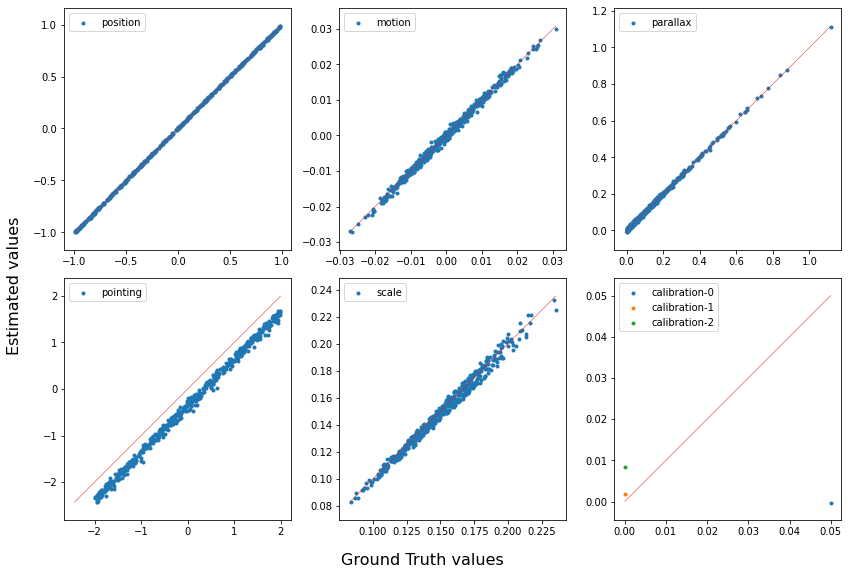

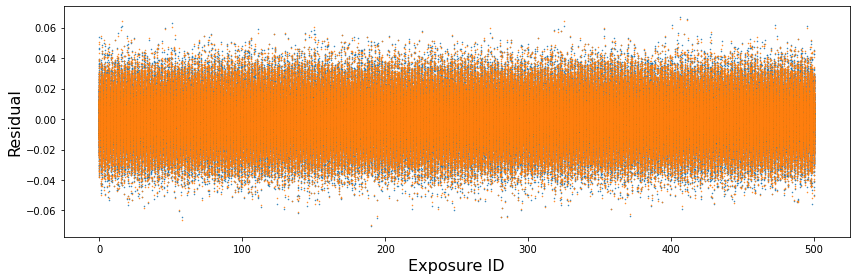

In [35]:
visualize(sx, ex, cx)
